In [ ]:
!pip install squarify

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/1

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

# Import packages for warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (750000, 10)
Test: (250000, 9)


In [ ]:
train_df.head()

,id,temparature,humidity,moisture,soil_type,crop_type,nitrogen,potassium,phosphorous,fertilizer_name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [ ]:
# Change column names to lower_case & replace space with underscore
train_df.columns = train_df.columns.str.replace(' ', '_').str.lower()
test_df.columns = test_df.columns.str.replace(' ', '_').str.lower()

In [ ]:
print("Missing Values in Train:", train_df.isna().sum().sum())
print("Missing Values in Test:", test_df.isna().sum().sum())

print("Duplicates in Train:", train_df.drop(columns=['id']).duplicated().sum())
print("Duplicates in Test:", test_df.drop(columns=['id']).duplicated().sum())

Missing Values in Train: 0
Missing Values in Test: 0
Duplicates in Train: 0
Duplicates in Test: 0


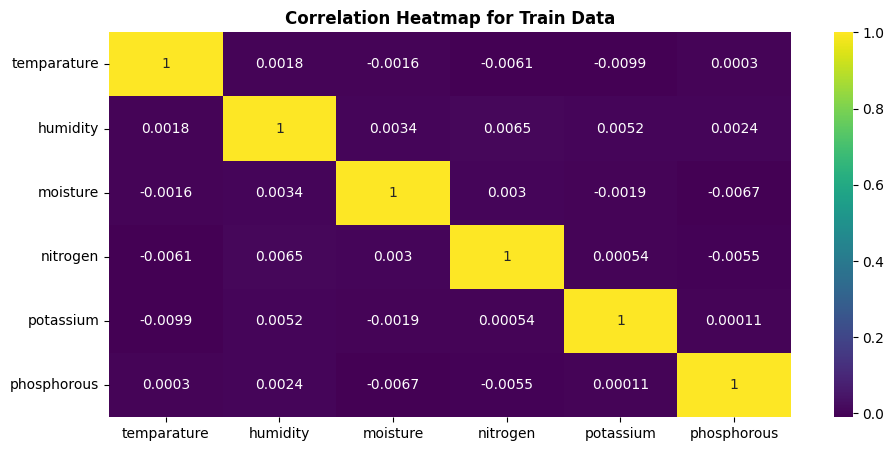

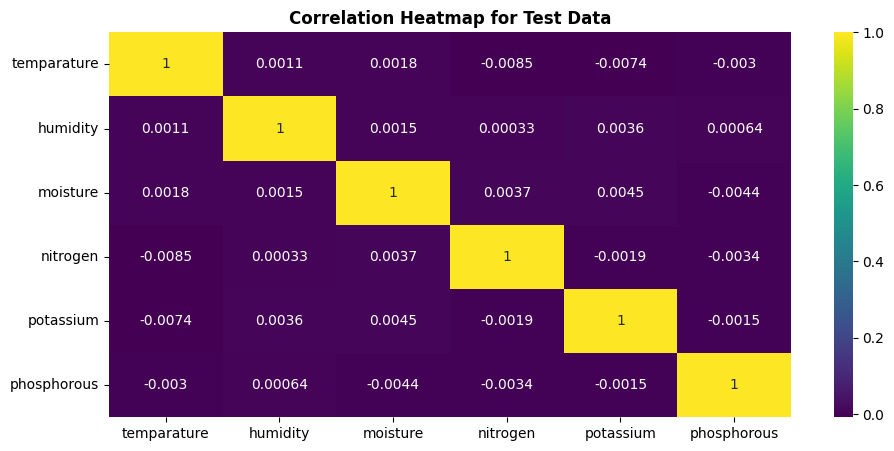

In [ ]:
# Heatmap for train_df
plt.figure(figsize=(11, 5))
sns.heatmap(train_df.drop(columns=['id']).corr(method='pearson', numeric_only=True), annot=True, cmap='viridis')
plt.title('Correlation Heatmap for Train Data', fontsize=12, weight='bold')
plt.show();

# Heatmap for test_df
plt.figure(figsize=(11, 5))
sns.heatmap(test_df.drop(columns=['id']).corr(method='pearson', numeric_only=True), annot=True, cmap='viridis')
plt.title('Correlation Heatmap for Test Data', fontsize=12, weight='bold')
plt.show();

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   temparature      750000 non-null  int64 
 2   humidity         750000 non-null  int64 
 3   moisture         750000 non-null  int64 
 4   soil_type        750000 non-null  object
 5   crop_type        750000 non-null  object
 6   nitrogen         750000 non-null  int64 
 7   potassium        750000 non-null  int64 
 8   phosphorous      750000 non-null  int64 
 9   fertilizer_name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


In [ ]:
for col in train_df.select_dtypes('object').columns:
    train_df[col] = train_df[col].astype('category')

# Changing the datatype for categorical variables from object to category in test_df
for col in test_df.select_dtypes('object').columns:
    test_df[col] = test_df[col].astype('category')

In [ ]:
le = LabelEncoder()

train_df['fertilizer_name'] = le.fit_transform(train_df['fertilizer_name'])


In [ ]:
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [ ]:

continuous_column = ['temparature','humidity','moisture','nitrogen','potassium','phosphorous']
categorical_column = list(train_df.columns.difference(continuous_column))
print("categorical_column=",categorical_column)
print("continuous_column=",continuous_column)

categorical_column= ['crop_type', 'fertilizer_name', 'soil_type']
continuous_column= ['temparature', 'humidity', 'moisture', 'nitrogen', 'potassium', 'phosphorous']


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   temparature      750000 non-null  int64 
 1   humidity         750000 non-null  int64 
 2   moisture         750000 non-null  int64 
 3   soil_type        750000 non-null  object
 4   crop_type        750000 non-null  object
 5   nitrogen         750000 non-null  int64 
 6   potassium        750000 non-null  int64 
 7   phosphorous      750000 non-null  int64 
 8   fertilizer_name  750000 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 51.5+ MB


In [ ]:
print(train_df['fertilizer_name'].value_counts())
print(train_df['fertilizer_name'].unique())

fertilizer_name
1    114436
0    113887
2    112453
4    111158
3    110889
5     94860
6     92317
Name: count, dtype: int64
[4 2 0 5 3 1 6]


In [ ]:

y = train_df['fertilizer_name']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
from pycaret.classification import * # 분류 모듈 임포트
import pandas as pd

# 'fertilizer_name' 컬럼은 target이므로 categorical_features 리스트에서 제거합니다.
# PyCaret setup 함수는 target 컬럼을 features에서 자동으로 분리하여 처리합니다.
categorical_column = ['crop_type', 'soil_type'] # 'fertilizer_name' 제거됨
continuous_column= ['temparature', 'humidity', 'moisture', 'nitrogen', 'potassium', 'phosphorous']


# PyCaret 분류 setup 함수 호출
# target 컬럼 'fertilizer_name'은 이제 다중 클래스 분류의 타겟입니다.
pyc_clf = setup(
    data=train_df,
    target='fertilizer_name',  # 예측하고자 하는 target 컬럼을 명시합니다. (다중 클래스 분류)
    categorical_features=categorical_column, # 'fertilizer_name'이 제거된 리스트 사용
    numeric_features=continuous_column,
    train_size=0.8,
    normalize=True,
    normalize_method='minmax',
    session_id=42,
)

# 여러 분류 모델을 비교하고 가장 좋은 모델 선택
# sort 기준을 'Accuracy', 'AUC', 'F1', 'Recall', 'Precision', 'MCC' 등으로 변경할 수 있습니다.
# 다중 클래스 분류에서는 'Accuracy'나 'F1' (weighted/macro/micro), 'MCC' 등이 자주 사용됩니다.
# 'AUC'는 다중 클래스에서 일반적으로 'Weighted AUC'로 계산됩니다.
models = compare_models(
    fold=3,
    sort='Accuracy',  # 다중 클래스 분류에서는 'Accuracy' 또는 'F1' (weighted)이 일반적입니다.
    n_select=4,
    include=['lr', 'dt', 'rf', 'gbc', 'xgboost', 'lightgbm', 'ada'] # 분류 모델 ID
)

,Description,Value
0,Session id,42
1,Target,fertilizer_name
2,Target type,Multiclass
3,Target mapping,"10-26-26: 0, 14-35-14: 1, 17-17-17: 2, 20-20: 3, 28-28: 4, DAP: 5, Urea: 6"
4,Original data shape,"(750000, 9)"
5,Transformed data shape,"(750000, 23)"
6,Transformed train set shape,"(600000, 23)"
7,Transformed test set shape,"(150000, 23)"
8,Numeric features,6
9,Categorical features,2


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.1917,0.5657,0.1917,0.1911,0.1871,0.0526,0.0529,55.3933
lightgbm,Light Gradient Boosting Machine,0.1855,0.5580,0.1855,0.1857,0.1772,0.0442,0.0447,92.5633
gbc,Gradient Boosting Classifier,0.1791,0.0000,0.1791,0.1803,0.1634,0.0351,0.0358,547.0833
ada,Ada Boost Classifier,0.1653,0.0000,0.1653,0.1630,0.1496,0.0191,0.0195,32.4933
rf,Random Forest Classifier,0.1634,0.5267,0.1634,0.1619,0.1613,0.0207,0.0207,155.5600
lr,Logistic Regression,0.1590,0.0000,0.1590,0.1549,0.1392,0.0113,0.0116,16.0133
dt,Decision Tree Classifier,0.1505,0.5039,0.1505,0.1505,0.1505,0.0078,0.0078,15.7767


Processing:   0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
def create_features(df):
    # Categorical combos
    df['soil_crop_combo'] = df['soil_type'] +  "_" + df['crop_type']
    df['npk_sum'] = df['nitrogen'] + df['potassium'] + df['phosphorous']

    # Climate difference
    df['temp_moisture_diff'] = df['temparature'] - df['moisture']
    df['humidity_temp_diff'] = df['humidity'] - df['temparature']
    df['humidity_moisture_diff'] = df['humidity'] - df['moisture']

    # Climate ratio
    df['humidity_moisture_ratio'] = df['humidity'] / df['moisture']
    df['temp_humidity_ratio'] = df['temparature'] / df['humidity']
    df['temp_moisture_ratio'] = df['temparature'] / df['moisture']

    # Climate normalized ratios
    df['climate_sum'] = df['temparature'] + df['humidity'] + df['moisture']
    df['temp_pct'] = df['temparature'] / df['climate_sum']
    df['humidity_pct'] = df['humidity'] / df['climate_sum']
    df['moisture_pct'] = df['moisture'] / df['climate_sum']

    # Interaction features
    df['temp_humidity_moisture'] = df['temparature'] * df['humidity'] * df['moisture']
    df['nitrogen_phosphorous_potassium'] = df['nitrogen'] * df['phosphorous'] * df['potassium']

    # NPK ratios
    df['n_p_ratio'] = df['nitrogen'] / np.where(df['phosphorous'] == 0, 1, df['phosphorous'])
    df['n_k_ratio'] = df['nitrogen'] / np.where(df['potassium'] == 0, 1, df['potassium'])
    df['p_k_ratio'] = df['phosphorous'] / np.where(df['potassium'] == 0, 1, df['potassium'])

    # Nutrient balance index
    df['npk_balance'] = df['npk_sum'] / 3 - np.std([df['nitrogen'], df['phosphorous'], df['potassium']], axis=0)
    # Heat-drought stress signal
    df['hot_dry_conditions'] = df['temp_pct'] * (1 - df['humidity_pct'])
    # Balanced climate score
    df['ideal_growing_conditions'] = 1 / (1 + abs(df['temp_pct'] - 0.33) + abs(df['humidity_pct'] - 0.33) + abs(df['moisture_pct'] - 0.33))

    return df


def create_interaction_features(df):
    # Create climate interaction features
    climate_features = ['temparature', 'humidity', 'moisture']
    for i, col1 in enumerate(climate_features):
        for col2 in climate_features[i+1:]:
            df[f"{col1}_x_{col2}"] = df[col1] * df[col2]

    # Create NPK interaction featuers
    npk_features = ['nitrogen',	'potassium', 'phosphorous']
    for i, col1 in enumerate(npk_features):
        for col2 in npk_features[i+1:]:
            df[f"{col1}_x_{col2}"] = df[col1] * df[col2]

    # Create selective climate & npk interaction features
    df['nitrogen_x_temp'] = df['nitrogen'] * df['temparature']
    df['phosphorous_x_moisture'] = df['phosphorous'] * df['moisture']
    df['npk_sum_x_temp'] = df['npk_sum'] * df['temparature']
    df['potassium_x_humidity'] = df['potassium'] * df['humidity']

    return df

# Apply create_features
train_df = create_features(train_df)
test_df = create_features(test_df)

# Apply create_interaction_features
train_df = create_interaction_features(train_df)
test_df = create_interaction_features(test_df)
train_df.head(1)

,id,temparature,humidity,moisture,soil_type,crop_type,nitrogen,potassium,phosphorous,fertilizer_name,soil_crop_combo,npk_sum,temp_moisture_diff,humidity_temp_diff,humidity_moisture_diff,humidity_moisture_ratio,temp_humidity_ratio,temp_moisture_ratio,climate_sum,temp_pct,humidity_pct,moisture_pct,temp_humidity_moisture,nitrogen_phosphorous_potassium,n_p_ratio,n_k_ratio,p_k_ratio,npk_balance,hot_dry_conditions,ideal_growing_conditions,temparature_x_humidity,temparature_x_moisture,humidity_x_moisture,nitrogen_x_potassium,nitrogen_x_phosphorous,potassium_x_phosphorous,nitrogen_x_temp,phosphorous_x_moisture,npk_sum_x_temp,potassium_x_humidity
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,Clayey_Sugarcane,45,1,33,34,1.944444,0.528571,1.027778,143,0.258741,0.48951,0.251748,93240,720,7.2,9.0,1.25,0.145147,0.132085,0.76393,2590,1332,2520,144,180,20,1332,180,1665,280


In [ ]:
def create_fertilizer_prob_features(train_df, group_col, target_col):
    fertilizer_ohe = pd.get_dummies(train_df[target_col], prefix='prob_', dtype=float)
    temp_df = pd.concat([train_df[group_col].reset_index(drop=True), fertilizer_ohe], axis=1)
    group_prob = temp_df.groupby(group_col).mean().reset_index()

    train_df = train_df.merge(group_prob, on=group_col, how='left')

    return train_df

In [ ]:
X_train = create_fertilizer_prob_features(
    train_df,
    group_col='soil_type',
    target_col='fertilizer_name'
)

In [ ]:
X_train = X_train.drop(['id'], axis=1)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 46 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   temparature                     750000 non-null  int64   
 1   humidity                        750000 non-null  int64   
 2   moisture                        750000 non-null  int64   
 3   soil_type                       750000 non-null  category
 4   crop_type                       750000 non-null  category
 5   nitrogen                        750000 non-null  int64   
 6   potassium                       750000 non-null  int64   
 7   phosphorous                     750000 non-null  int64   
 8   fertilizer_name                 750000 non-null  category
 9   soil_crop_combo                 750000 non-null  category
 10  npk_sum                         750000 non-null  int64   
 11  temp_moisture_diff              750000 non-null  int64   
 12  hu

In [ ]:
columns_with_cotton = []

# 모든 컬럼을 순회
for column in X_train.columns:
    # 현재 컬럼에 'Cotton' 값이 하나라도 있는지 확인
    if (X_train[column] == 'Cotton').any():
        columns_with_cotton.append(column)

# 결과 출력
print("컬럼에 'Cotton'이 포함된 컬럼명:")
for col_name in columns_with_cotton:
    print(col_name)

컬럼에 'Cotton'이 포함된 컬럼명:
crop_type


In [ ]:
for col in X_train.select_dtypes('object').columns:
    X_train[col] = X_train[col].astype('category')

In [ ]:
categorical_column = ['soil_type', 'crop_type', 'soil_crop_combo']

continuous_column = list(X_train.columns.difference(continuous_column + ['fertilizer_name']))
print("categorical_column=",categorical_column)
print("continuous_column=",continuous_column)

categorical_column= ['soil_type', 'crop_type', 'soil_crop_combo']
continuous_column= ['humidity', 'moisture', 'nitrogen', 'phosphorous', 'potassium', 'prob__10-26-26', 'prob__14-35-14', 'prob__17-17-17', 'prob__20-20', 'prob__28-28', 'prob__DAP', 'prob__Urea', 'temparature']


In [ ]:
from pycaret.classification import * # 분류 모듈 임포트
import pandas as pd

# PyCaret 분류 setup 함수 호출
# target 컬럼 'fertilizer_name'은 이제 다중 클래스 분류의 타겟입니다.
pyc_clf = setup(
    data=X_train,
    target='fertilizer_name',  # 예측하고자 하는 target 컬럼을 명시합니다. (다중 클래스 분류)
    categorical_features=categorical_column, # 'fertilizer_name'이 제거된 리스트 사용
    numeric_features=continuous_column,
    train_size=0.8,
    normalize=True,
    normalize_method='minmax',
    session_id=42,
)

# 여러 분류 모델을 비교하고 가장 좋은 모델 선택
# sort 기준을 'Accuracy', 'AUC', 'F1', 'Recall', 'Precision', 'MCC' 등으로 변경할 수 있습니다.
# 다중 클래스 분류에서는 'Accuracy'나 'F1' (weighted/macro/micro), 'MCC' 등이 자주 사용됩니다.
# 'AUC'는 다중 클래스에서 일반적으로 'Weighted AUC'로 계산됩니다.
models = compare_models(
    fold=3,
    sort='Accuracy',  # 다중 클래스 분류에서는 'Accuracy' 또는 'F1' (weighted)이 일반적입니다.
    n_select=4,
    include=['lr', 'dt', 'rf', 'gbc', 'xgboost', 'lightgbm', 'ada'] # 분류 모델 ID
)